#### Pre-processing I

In [1]:
import os 
# change wd
os.chdir('..')
!pwd

/Users/cshatto/Projects/fire-recovery


In [2]:
import satpy
print(f"satpy version: {satpy.__version__}")

satpy version: 0.56.0


In [3]:
from satpy.utils import check_satpy
# from satpy.utils import debug_on
# debug_on()
check_satpy(readers=['msi_safe_l2a', 'msi_safe', 'generic_image'],
            writers=['geotiff', 'cf', 'simple_image'])

Readers
generic_image:  ok
msi_safe:  ok
msi_safe_l2a:  ok

Writers
cf:  ok
geotiff:  ok
simple_image:  ok

Versions
platform: macOS-15.4.1-arm64-arm-64bit-Mach-O
python: 3.13.3

cartopy: 0.24.1
dask: 2025.5.0
fsspec: 2025.3.2
gdal: not installed
geoviews: 1.14.0
h5netcdf: 1.6.1
h5py: 3.13.0
netcdf4: 1.7.2
numpy: 2.2.5
pyhdf: 0.11.6
pyproj: 3.7.1
rasterio: 1.4.3
xarray: 2025.1.1



In [4]:
!gdalinfo data/safe_rasters/S2A_MSIL2A_20240915T112111_N0511_R037_T29TNF_20240915T155449/S2A_MSIL2A_20240915T112111_N0511_R037_T29TNF_20240915T155449.SAFE/GRANULE/L2A_T29TNF_A048225_20240915T112112/IMG_DATA/R10m/T29TNF_20240915T112111_B02_10m.jp2

Driver: JP2OpenJPEG/JPEG-2000 driver based on JP2OpenJPEG library
Files: data/safe_rasters/S2A_MSIL2A_20240915T112111_N0511_R037_T29TNF_20240915T155449/S2A_MSIL2A_20240915T112111_N0511_R037_T29TNF_20240915T155449.SAFE/GRANULE/L2A_T29TNF_A048225_20240915T112112/IMG_DATA/R10m/T29TNF_20240915T112111_B02_10m.jp2
Size is 10980, 10980
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 29N",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            MEMBER["World Geodetic System 1984 (G2139)"],
            MEMBER["World Geodetic System 1984 (G2296)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
              

collect safe files

In [5]:
from glob import glob
from satpy.readers import find_files_and_readers
# Get list of SAFE directories
safe_dirs = glob("data/safe_rasters/*")

# Collect files for each SAFE directory
scene_files = []
for safe_dir in safe_dirs:
    files = find_files_and_readers(base_dir=safe_dir, reader="msi_safe_l2a")
    scene_files.append(files)

read safes into scenes and sort by start time, then load scenes into multiscene

In [6]:
from satpy import Scene
scenes = []
for files in scene_files:
    scn = Scene(reader="msi_safe_l2a", filenames=files)
    scn.load(["B04","B08","B12","ndvi_l2a", "natural_color_l2a"],calibration="reflectance") 
    scenes.append(scn)
scenes = sorted(scenes, key=lambda scn: scn.start_time)

/Users/cshatto/Projects/fire-recovery/venv/lib/python3.13/site-packages/satpy/readers/msi_safe.py:97: UserWarning: The specified chunks separate the stored chunks along dimension "y" starting at index 4096. This could degrade performance. Instead, consider rechunking after loading.
  proj = xr.open_dataset(self.filename, engine="rasterio", chunks=CHUNK_SIZE)["band_data"]
/Users/cshatto/Projects/fire-recovery/venv/lib/python3.13/site-packages/satpy/readers/msi_safe.py:97: UserWarning: The specified chunks separate the stored chunks along dimension "x" starting at index 4096. This could degrade performance. Instead, consider rechunking after loading.
  proj = xr.open_dataset(self.filename, engine="rasterio", chunks=CHUNK_SIZE)["band_data"]
/Users/cshatto/Projects/fire-recovery/venv/lib/python3.13/site-packages/satpy/readers/msi_safe.py:97: UserWarning: The specified chunks separate the stored chunks along dimension "y" starting at index 4096. This could degrade performance. Instead, cons

In [7]:
from satpy import MultiScene
mscn = MultiScene(scenes)

#### Bounding box, location of fires in Portugal
- South West: 41.06626°, -8.24721°
- North East: 41.48443°, -7.48991°

resample multiscene to area of interest

In [8]:
from pyresample.geometry import AreaDefinition

# challenge info
area_id = "northern_portugal"
description = "Northern Portugal region"
proj_id = "latlong"
projection = {"proj": "latlong", "datum": "WGS84"}
width = 1000
height = 1000
area_extent = (-8.24721, 41.06626, -7.48991, 41.48443)  # South West to North East
area_def = AreaDefinition(area_id, description, proj_id, projection, width, height, area_extent)

# Resample images to same grid and resolution
mscn = mscn.resample(area_def)

group (mosaic) neighboring tiles together by date

In [9]:
from datetime import timedelta
# Group scenes by date (1-day threshold) and mosaic
threshold = timedelta(days=1)
mosaicked_scenes = []
scenes = list(mscn.scenes)
while scenes:
    group = [scenes[0]]
    ref_time = scenes[0].start_time
    for s in scenes[1:]:
        if abs(s.start_time - ref_time) <= threshold:
            group.append(s)
    for s in group:
        scenes.remove(s)
    # Mosaic tiles in the group into a single Scene
    group_mscn = MultiScene(group)
    blended = group_mscn.blend()  # Default stack mosaics tiles
    mosaicked_scenes.append(blended)

mscn = MultiScene(mosaicked_scenes)

calculate nbr and ndvi, then clip to valid index ranges

In [10]:
import numpy as np
for scene in mscn.scenes:
    b08 = scene['B08'].compute()
    b12 = scene['B12'].compute()
    nbr = (b08 - b12) / (b08 + b12 + 1e-10)    
    nbr = np.clip(nbr, -1, 1)
    nbr.attrs = scene['B08'].attrs
    ndvi = scene['ndvi_l2a'].compute()
    ndvi = np.clip(ndvi, -1, 1)
    ndvi.attrs = scene['B08'].attrs
    scene['ndvi'] = ndvi
    scene['nbr'] = nbr

/Users/cshatto/Projects/fire-recovery/venv/lib/python3.13/site-packages/dask/_task_spec.py:764: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/Users/cshatto/Projects/fire-recovery/venv/lib/python3.13/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/Users/cshatto/Projects/fire-recovery/venv/lib/python3.13/site-packages/dask/_task_spec.py:764: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/Users/cshatto/Projects/fire-recovery/venv/lib/python3.13/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/Users/cshatto/Projects/fire-recovery/venv/lib/python3.13/site-packages/dask/_task_spec.py:764: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/Users/cshatto/Projects/fire-recovery/venv/lib/python3.13/site-packages/dask/_task_spec.py:7

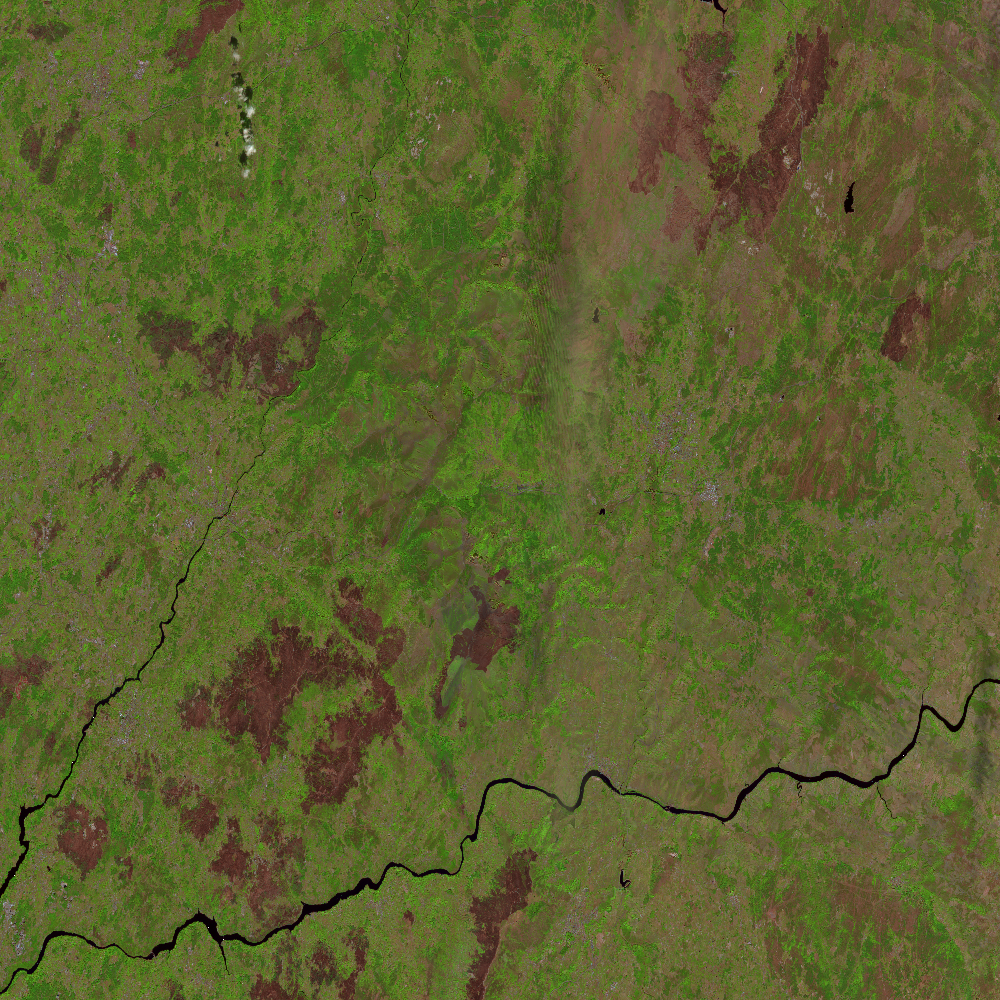

In [11]:
mscn.scenes[1].show('natural_color_l2a')

In [12]:
mscn.scenes[1]['ndvi_l2a'].dtype

dtype('float32')

fun mp4 animation from satpy package

In [ ]:
%%time
mscn.save_animation('data/output/satpy_animations/{name}_{start_time:%Y%m%d_%H%M%S}.mp4', fps=1)

save to geotiffs



In [13]:
# TODO preserve float32 values
for scene in mscn.scenes:
    safe_name = f"S2A_MSIL2A_{scene.start_time.strftime('%Y%m%dT%H%M%S')}"    
    for dataset in ['natural_color_l2a', 'ndvi', 'nbr']:
        scene.save_dataset(
            dataset,
            writer='geotiff',
            filename=f"data/satpy_geotiffs/{safe_name}_{dataset}.tif"
        )

#### Preprocessing II

dnbr vectorization of BAs

In [14]:
scene_pre, scene_post = list(mscn.scenes)[:2]

# Compute dNBR (NBR_pre - NBR_post)
nbr_pre = scene_pre['nbr'].compute()
nbr_post = scene_post['nbr'].compute()
dnbr = nbr_pre - nbr_post
dnbr.attrs = scene_pre['nbr'].attrs
scene_post['dnbr'] = dnbr.astype('float32')

In [15]:
ba_mask = (dnbr >= 0.3).astype('uint8') # could be higher for severe fires but will do pix count later
ba_mask.attrs = scene_post.attrs
scene_post['ba_mask'] = ba_mask

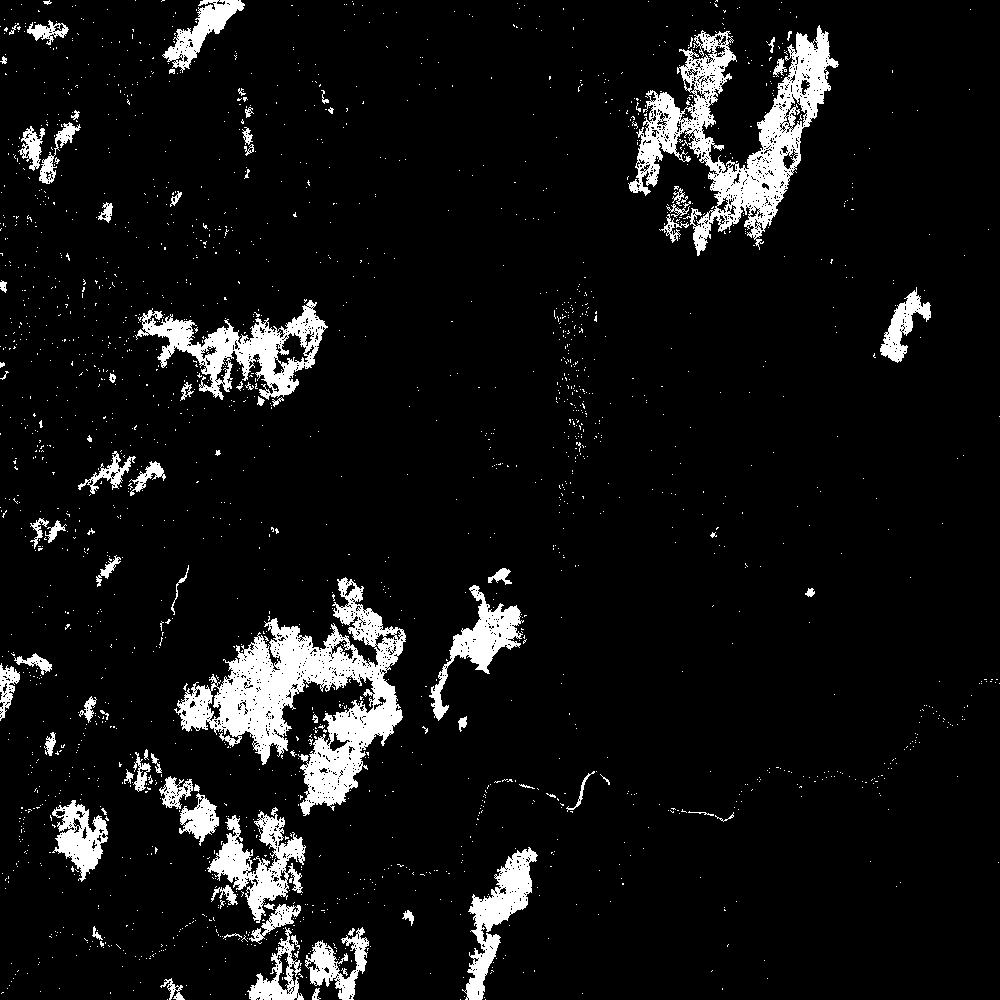

In [16]:
scene_post.show('ba_mask')

In [ ]:
from scipy.ndimage import label
# Identify connected clusters and filter by size, 150 is best sofar
structure = np.ones((3, 3), dtype=np.uint8)  
labeled_array, num_features = label(ba_mask.values, structure=structure)
filtered_mask = np.zeros_like(labeled_array, dtype=np.uint8)
if num_features > 0:
    for i in range(1, num_features + 1):
        cluster_size = np.sum(labeled_array == i)
        if cluster_size > 150:  
            filtered_mask[labeled_array == i] = 1

In [19]:
import xarray as xr
ba_mask_filtered = xr.DataArray(
    filtered_mask,
    coords=ba_mask.coords,
    dims=ba_mask.dims,
    attrs=ba_mask.attrs
).astype('uint8')
scene_post['ba_mask'] = ba_mask_filtered

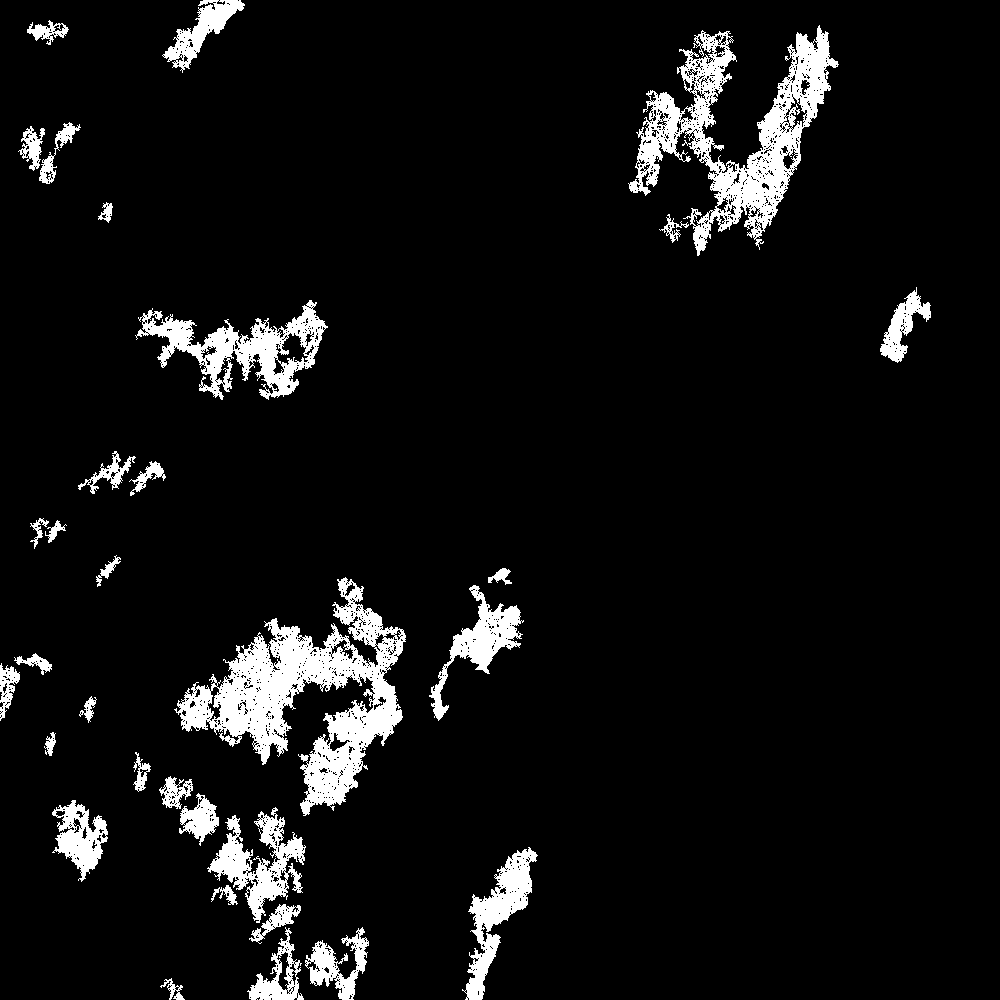

In [20]:
scene_post.show('ba_mask')

vectorize recovery

In [23]:
import rioxarray
from rasterio.features import shapes
from shapely.geometry import shape, MultiPolygon
import geopandas as gpd

#temp file just for vectorization
temp_tif = 'temp_ba_mask.tif'
scene_post['ba_mask'].rio.to_raster(temp_tif, driver='GTiff')

#vectorize mask using rasterio shapes combined with shapley shape
with rioxarray.open_rasterio(temp_tif) as src:
    mask_data = src.squeeze().values
    transform = src.rio.transform()
    crs = src.rio.crs
    shapes_gen = shapes(mask_data, mask=mask_data == 1, transform=transform)
    polygons = [shape(geom) for geom, value in shapes_gen if value == 1]

# Save 
ba = MultiPolygon(polygons) if polygons else MultiPolygon()
gdf = gpd.GeoDataFrame(geometry=[ba], crs=crs)
gdf.to_file('data/output/burn_areas.geojson')

<Axes: >

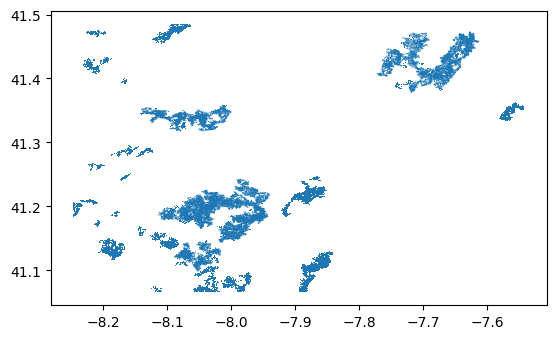

In [24]:
gdf.plot()

#### Classification

In [25]:
import xarray as xr
import rioxarray
import numpy as np
from rasterio.features import shapes
from shapely.geometry import shape, MultiPolygon
import geopandas as gpd
import os

# Scenes: 2024-09-30 (1), 2024-11-09 (2), 2025-04-23 (3)
scene_sept, scene_nov, scene_apr = mscn.scenes[1:4]

# Load NDVI and mask
for scene in [scene_sept, scene_nov, scene_apr]:
    scene.load(['ndvi'])
ndvi_sept = scene_sept['ndvi'].compute()
ndvi_nov = scene_nov['ndvi'].compute()
ndvi_apr = scene_apr['ndvi'].compute()
ba_mask = scene_sept['ba_mask'].compute()

# 2024-11-09 dNDVI
scene_nov['dndvi'] = (ndvi_nov - ndvi_sept).where(ba_mask == 1, np.nan)
scene_nov['recovery_mask'] = xr.where(ba_mask == 1, np.select(
    [scene_nov['dndvi'] < 0.1, scene_nov['dndvi'] < 0.4, scene_nov['dndvi'] >= 0.4],
    [1, 2, 3], 0
), 0).astype('uint8')

# 2025-04-23 dNDVI
scene_apr['dndvi'] = (ndvi_apr - ndvi_sept).where(ba_mask == 1, np.nan)
scene_apr['recovery_mask'] = xr.where(ba_mask == 1, np.select(
    [scene_apr['dndvi'] < 0.1, scene_apr['dndvi'] < 0.4, scene_apr['dndvi'] >= 0.4],
    [1, 2, 3], 0
), 0).astype('uint8')

# Vectorize and save
for scene, date in [(scene_nov, '20241109'), (scene_apr, '20250423')]:
    temp_tif = f'temp_recovery_{date}.tif'
    scene['recovery_mask'].rio.to_raster(temp_tif)
    with rioxarray.open_rasterio(temp_tif) as src:
        mask_data = src.squeeze().values
        transform = src.rio.transform()
        polygons = [
            {'geometry': shape(geom), 'recovery': {1: 'No Recovery', 2: 'Moderate Recovery', 3: 'High Recovery'}[val]}
            for val in [1, 2, 3] for geom, val in shapes(mask_data, mask=mask_data == val, transform=transform)
            if shape(geom).is_valid
        ]
    gdf = gpd.GeoDataFrame(polygons, crs='EPSG:4326')
    gdf.to_file(f'data/output/classification/thresh_areas_{date}.geojson') if not gdf.empty else gpd.GeoDataFrame(geometry=[shape(MultiPolygon())], crs='EPSG:4326').to_file(f'data/output/classification/recovery_areas_{date}.geojson')
    os.remove(temp_tif)

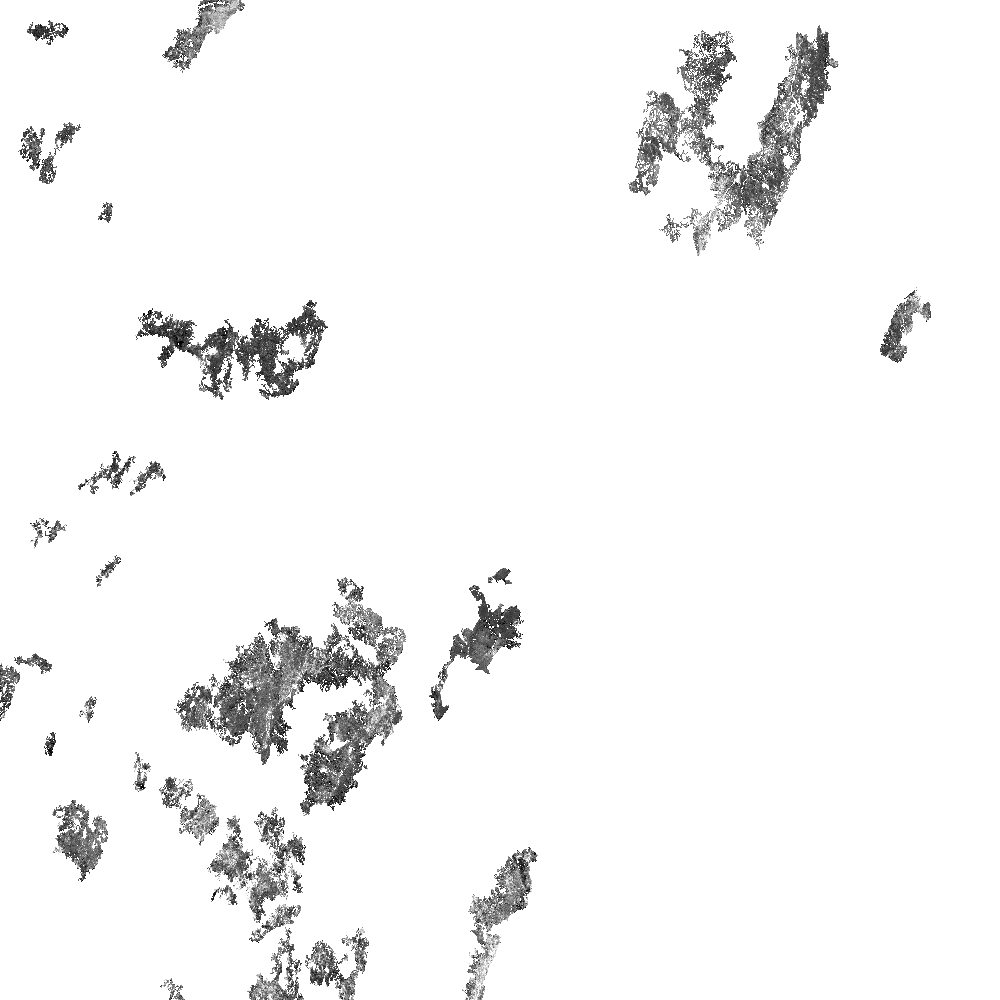

In [26]:
mscn.scenes[2].show('dndvi')

/var/folders/cm/bbv94sdx5212wy2c4pv0g21r0000gn/T/ipykernel_26411/3713017396.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Recovery', y='Area (ha)', palette=[colors[i] for i in [1, 2, 3]])


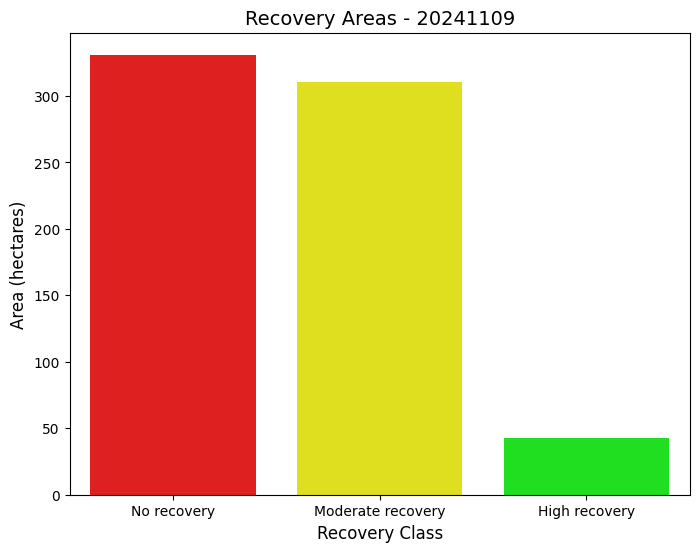

/var/folders/cm/bbv94sdx5212wy2c4pv0g21r0000gn/T/ipykernel_26411/3713017396.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Recovery', y='Area (ha)', palette=[colors[i] for i in [1, 2, 3]])


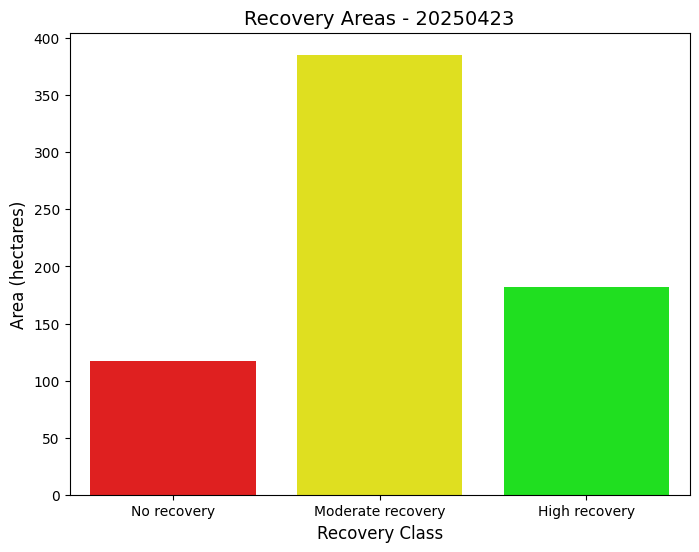

ba_mask_filtered pixels=68423


In [28]:
import xarray as xr
import numpy as np
from rasterio.features import shapes
from shapely.geometry import shape
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

scene_sept, scene_nov, scene_apr = mscn.scenes[1:4]

colors = {1: '#FF0000CC', 2: '#FFFF00CC', 3: '#00FF00CC'}
labels = {1: 'No recovery', 2: 'Moderate recovery', 3: 'High recovery'}

def vectorize_recovery(scene):
    mask_data = scene['recovery_mask'].values
    transform = scene['recovery_mask'].rio.transform()
    crs = scene['recovery_mask'].rio.crs
    polygons = [
        {'geometry': shape(geom), 'recovery': val}
        for val in [1, 2, 3] for geom, val in shapes(mask_data, mask=mask_data == val, transform=transform)
        if shape(geom).is_valid
    ]
    return gpd.GeoDataFrame(polygons, crs=crs) if polygons else gpd.GeoDataFrame(geometry=[], crs=crs)

def plot_bar_chart(gdf, date, labels):
    gdf['area_ha'] = gdf.geometry.area / 10000
    areas = gdf.groupby('recovery')['area_ha'].sum().reindex([1, 2, 3], fill_value=0)
    df = pd.DataFrame({
        'Recovery': [labels.get(i, 'Unknown') for i in [1, 2, 3]],
        'Area (ha)': areas.values
    })
    plt.figure(figsize=(8, 6))
    sns.barplot(data=df, x='Recovery', y='Area (ha)', palette=[colors[i] for i in [1, 2, 3]])
    plt.title(f'Recovery Areas - {date}', fontsize=14)
    plt.xlabel('Recovery Class', fontsize=12)
    plt.ylabel('Area (hectares)', fontsize=12)
    plt.savefig(f'data/output/classification/recovery_bar_{date}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

for scene, date in [(scene_nov, '20241109'), (scene_apr, '20250423')]:
    gdf = vectorize_recovery(scene)
    plot_bar_chart(gdf, date, labels)

print(f"ba_mask_filtered pixels={scene_sept['ba_mask'].sum().values}")

In [ ]:
import geopandas as gpd
import folium
from folium.features import GeoJson, GeoJsonTooltip
import pandas as pd

# Load GeoDataFrames
try:
    gdf_20241109 = gpd.read_file('data/output/classification/thresh_areas_20241109.geojson')
    gdf_20250423 = gpd.read_file('data/output/classification/thresh_areas_20250423.geojson')
except Exception as e:
    print(f"Error loading gdfs: {e}")
    exit()

# Ensure CRS is EPSG:4326
if gdf_20241109.crs != "EPSG:4326":
    gdf_20241109 = gdf_20241109.to_crs("EPSG:4326")
if gdf_20250423.crs != "EPSG:4326":
    gdf_20250423 = gdf_20250423.to_crs("EPSG:4326")

# Validate geometries
gdf_20241109 = gdf_20241109[gdf_20241109.geometry.is_valid]
gdf_20250423 = gdf_20250423[gdf_20250423.geometry.is_valid]
print(f"Valid features after filtering (2024-11-09): {len(gdf_20241109)}")
print(f"Valid features after filtering (2025-04-23): {len(gdf_20250423)}")

# Exit if no valid features
if len(gdf_20241109) == 0 or len(gdf_20250423) == 0:
    print("Error: One or both GeoDataFrames are empty after validation.")
    exit()

# Prepare recovery columns
gdf_20241109['recovery_20241109'] = gdf_20241109.get('recovery', 'unknown').astype(str).replace('nan', 'unknown')
gdf_20250423['recovery_20250423'] = gdf_20250423.get('recovery', 'unknown').astype(str).replace('nan', 'unknown')

# Define color mapping
colors = {
    'No Recovery': '#FF0000CC',      # Red
    'Moderate Recovery': '#FFFF00CC', # Yellow
    'High Recovery': '#00FF00CC',     # Green
    'unknown': '#808080CC'   # Gray for missing/unknown
}

# Create Folium map
m = folium.Map(
    location=[(41.07 + 41.48) / 2, (-8.247 + -7.49) / 2],
    zoom_start=10,
    tiles='CartoDB positron',
    name='Light Basemap'
)

# Add satellite imagery layer
folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Satellite Imagery'
).add_to(m)

# Style functions
def style_nov(feature):
    recovery = feature['properties'].get('recovery_20241109', 'unknown')
    return {
        'fillColor': colors.get(recovery, '#00000080'),  # Default to black if value not in colors
        'color': 'black',
        'weight': 0,
        'fillOpacity': 0.6
    }

def style_apr(feature):
    recovery = feature['properties'].get('recovery_20250423', 'unknown')
    return {
        'fillColor': colors.get(recovery, '#00000080'),  # Default to black if value not in colors
        'color': 'black',
        'weight': 0,
        'fillOpacity': 0.6
    }

# Tooltips
tooltip_nov = folium.GeoJsonTooltip(
    fields=["recovery_20241109"],
    aliases=["2024-11-09"],
    labels=True,
    sticky=True,
    localize=True,
    style="font-size: 14px; font-weight: bold;"
)

tooltip_apr = folium.GeoJsonTooltip(
    fields=["recovery_20250423"],
    aliases=["2025-04-23"],
    labels=True,
    sticky=True,
    localize=True,
    style="font-size: 14px; font-weight: bold;"
)

# Add GeoJSON layers
folium.GeoJson(
    gdf_20241109,
    style_function=style_nov,
    tooltip=tooltip_nov,
    name='Recovery 2024-11-09'
).add_to(m)

folium.GeoJson(
    gdf_20250423,
    style_function=style_apr,
    tooltip=tooltip_apr,
    name='Recovery 2025-04-23'
).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Save map
m.save('data/output/classification/recovery_map.html')
print("Folium map saved as 'recovery_map.html'")